In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulate as sim

In [2]:
#starting with an [r,t,n] 
center_of_mass = np.array([[0,0,0]]).T
orbit_radius = 10

sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nx0 = sat1_x0/np.linalg.norm(sat1_x0)
sat1_v = 3 #u/s
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1]))

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nx0 = sat2_x0/np.linalg.norm(sat2_x0)
sat2_v = 3 #u/s
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1]))

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nx0 = sat3_x0/np.linalg.norm(sat3_x0)
sat3_v = 3 #u/s
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0]))



del_t = 1 #arbitrary time unit
n_orbits = 1
t = np.linspace(0,n_orbits*2*np.pi)
x1 = center_of_mass + orbit_radius * np.sin(t) * sat1_nv0 + orbit_radius * np.cos(t) * sat1_nx0
x2 = center_of_mass + orbit_radius * np.sin(t) * sat2_nv0 + orbit_radius * np.cos(t) * sat2_nx0
x3 = center_of_mass + orbit_radius * np.sin(t) * sat3_nv0 + orbit_radius * np.cos(t) * sat3_nx0



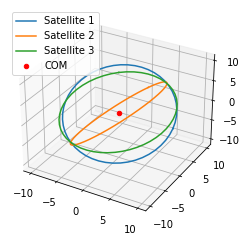

In [3]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(0,0,0,color='r',label="COM")

ax.plot(x1[0,:],x1[1,:],x1[2,:], label='Satellite 1')
ax.plot(x2[0,:],x2[1,:],x2[2,:], label='Satellite 2')
ax.plot(x3[0,:],x3[1,:],x3[2,:], label='Satellite 3')
ax.legend()
#ax.axis("equal")

plt.show()


In [4]:
orbit_radius = 10
sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1])).T

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1])).T

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0])).T

# Initialize 3 Observer Satellites
o1 = sim.observer(sat1_x0,sat1_nv0)
o2 = sim.observer(sat2_x0,sat2_nv0)
o3 = sim.observer(sat3_x0,sat3_nv0)

In [5]:
debris_points = np.array([[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1],[3,0,1],[3,0,-1],[-2,0,-1]]).T
    
    # Initialize the Quaternion for Debris Rotation. 
    # Given any normalized direction vector [nx,ny,nz] and angular rotation [omega], the quaternion is of the 
    # form: [nx*sin(omega/2),ny*sin(omega/2),nz*sin(omega/2),cos(omega/2)]
omega = .4 # rad/s
quat = np.array([0,1*np.sin(omega/2),0,np.cos(omega/2)])

# Initialize the Debris Object
deb = sim.debris(debris_points,quat)
mtest = sim.MeasurementModel(deb,np.array([o1,o2,o3]),n_blind=0)

In [6]:
import EKF_class as EKF
n = 39
mu0 = np.zeros((n))
mu0[6:] = debris_points.flatten()
sigma0 = 100* np.diag(np.ones((n)))

kalman_filter = EKF.KalmanFilter(mu0, sigma0)

In [7]:
t1 = np.linspace(0,60)

P_est_hist = np.zeros((len(t1), n, n))
x_est_hist = np.zeros((len(t1), n))
x_est_hist_min = np.zeros((len(t1), n))
for i in range(len(t1)):
    y = mtest[i].flatten() #replace with measurements
    sat_pos = o1[i].flatten()

    x_est_min, P_est = kalman_filter.predict()
    x_est, P_est = kalman_filter.update(y[:11], x_est_min, P_est, sat_pos)
  
    # Make sure to store the estimated state and covariance for analysis
    P_est_hist[i, :, :] = P_est
    x_est_hist[i, :] = x_est
    print('xest')
    print(x_est)
    x_est_hist_min[i, :] = x_est_min

State Transition Matrix A:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Predicted mu:
[ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1. -1. -1. -1. -1.  3.  3. -2.  1.
  1. -1. -1.  1.  1. -1. -1.  0.  0.  0.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1. -1.]
Predicted sigma:
[[100.005   0.      0.    ...   0.      0.      0.   ]
 [  0.    100.005   0.    ...   0.      0.      0.   ]
 [  0.      0.    100.005 ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ... 100.005   0.      0.   ]
 [  0.      0.      0.    ...   0.    100.005   0.   ]
 [  0.      0.      0.    ...   0.      0.    100.005]]
Kalman Gain K:
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.

In [8]:
print(x_est_hist_min[-1])

[  0.           0.           0.           0.           0.
   0.          -4.56252673   4.62290914 -12.57387576   7.02990951
 -12.03359996  -0.66175762   3.44168652  -2.60957938 -12.91680531
  -1.22145135  -0.43655954 -12.8240108   -7.85261296   3.48253135
 -12.08392785  -2.25965335   4.73762129 -13.3688403    6.26361438
  -7.61642696  -7.61642696  -4.64929176   1.6276281  -12.5545481
  -8.35178088   4.44592134  -7.67108838  -2.34869493 -10.57872562
   5.03503285  -9.1731331   -6.46623143   6.46935478]


## COM Plot

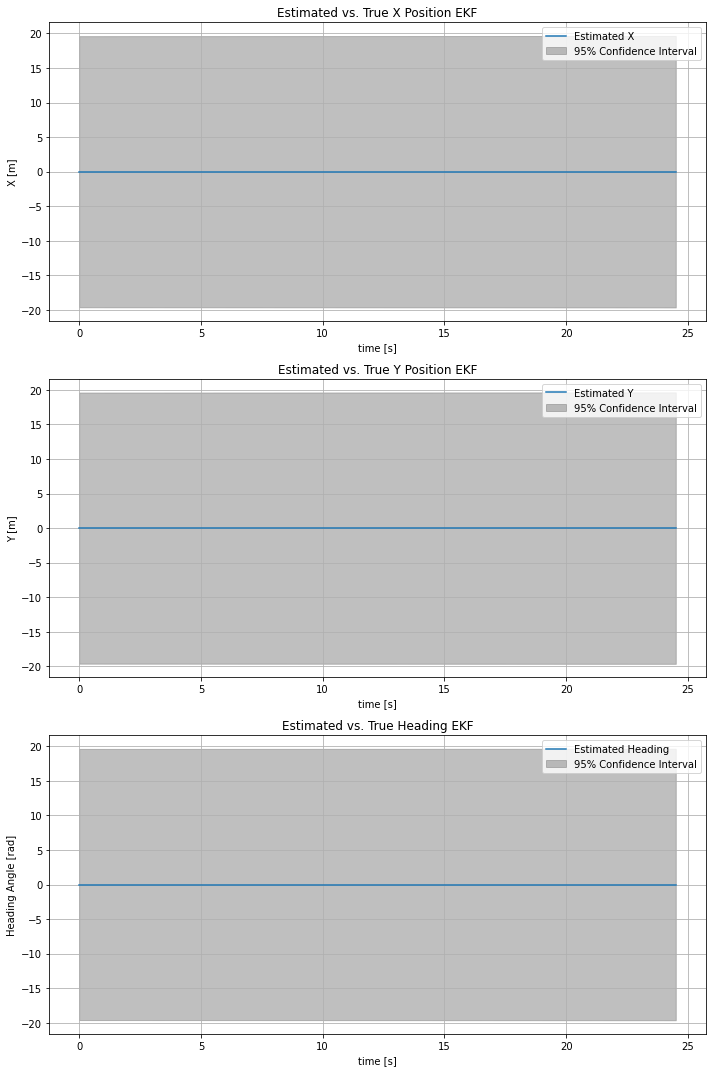

In [9]:
time_step = 0.5
time_array = np.arange(0, len(x_est_hist) * time_step, time_step)

std_dev_heading = np.sqrt(P_est_hist[:, 2, 2])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 0, 0])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 1, 1])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

#axs[0].plot(time_array, posehist[:, 0], label="True X")
axs[0].plot(time_array, x_est_hist[:, 0], label="Estimated X")
axs[0].fill_between(time_array, x_est_hist[:, 0] - confidence_interval_x, x_est_hist[:, 0] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('X [m]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Estimated vs. True X Position EKF')

# Plot Y Position
#axs[1].plot(time_array, posehist[:, 1], label="True Y")
axs[1].plot(time_array, x_est_hist[:, 1], label="Estimated Y")
axs[1].fill_between(time_array,  x_est_hist[:, 1] - confidence_interval_y, x_est_hist[:, 1] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Estimated vs. True Y Position EKF')

#axs[2].plot(time_array, posehist[:, 2], label="True Heading")
axs[2].plot(time_array, x_est_hist[:, 2], label="Estimated Heading")
axs[2].fill_between(time_array, x_est_hist[:, 2] - confidence_interval_heading, x_est_hist[:, 2] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Heading Angle [rad]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Heading EKF')

plt.tight_layout()
plt.show()




In [10]:
posehist = np.zeros((3, len(time_array)))

for t in range(len(time_array)):
    debr = deb[t].flatten()
    posehist[:, t] = debr[3:6]

posehist = posehist.T

In [14]:
print(x_est_hist_min[0, 9:12])
print(x_est_hist[0, 9:12])
print([posehist[1, :]])
print([mu0[9:12]])

[-8.75893856 -2.08432651 -2.08432651]
[array([ 0.53164265, -0.53164265, -1.31047934])]
[array([ 1., -1., -1.])]


## Estimate Point 3

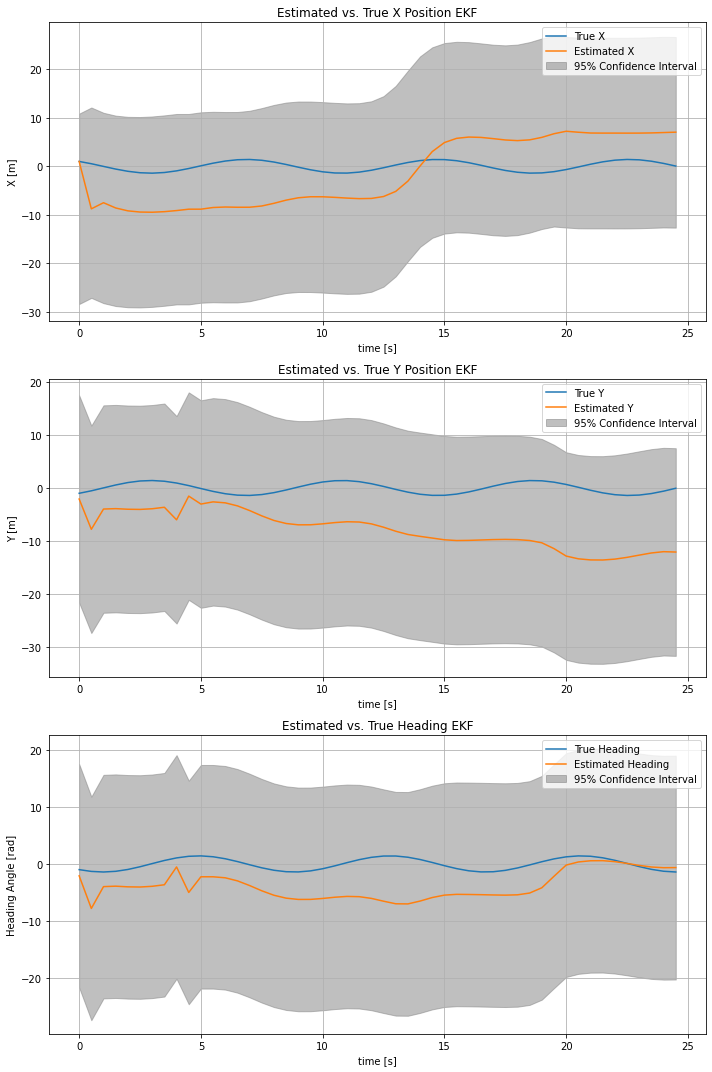

In [13]:
time_step = 0.5
time_array = np.arange(0, len(x_est_hist) * time_step, time_step)

std_dev_heading = np.sqrt(P_est_hist[:, 2, 2])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 0, 0])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 1, 1])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(time_array, posehist[:, 0], label="True X")
axs[0].plot(time_array, x_est_hist_min[:, 9], label="Estimated X")
axs[0].fill_between(time_array, x_est_hist[:,9] - confidence_interval_x, x_est_hist[:, 9] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('X [m]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Estimated vs. True X Position EKF')

# Plot Y Position
axs[1].plot(time_array, posehist[:, 1], label="True Y")
axs[1].plot(time_array, x_est_hist[:, 10], label="Estimated Y")
axs[1].fill_between(time_array,  x_est_hist[:, 10] - confidence_interval_y, x_est_hist[:, 10] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Estimated vs. True Y Position EKF')

axs[2].plot(time_array, posehist[:, 2], label="True Heading")
axs[2].plot(time_array, x_est_hist[:, 11], label="Estimated Heading")
axs[2].fill_between(time_array, x_est_hist[:, 11] - confidence_interval_heading, x_est_hist[:, 11] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Heading Angle [rad]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Heading EKF')

plt.tight_layout()
plt.show()


